In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [55]:
# Import the train data
data = pd.read_csv('train.csv')
data

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [56]:
# Convert date from object to datetime
data['date'] = pd.to_datetime(data['date'])
# extract the numbers from the datetime
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data = data.drop('date',axis=1)

# Modify the data made by caracters

label_encoder = LabelEncoder()

data['country'] = label_encoder.fit_transform(data['country'])
data['store'] = label_encoder.fit_transform(data['store'])
data['product'] = label_encoder.fit_transform(data['product'])

# Replace Nan for 0

data['num_sold'] = data['num_sold'].fillna(0)
data

,id,country,store,product,num_sold,year,month,day
0,0,0,0,0,0.0,2010,1,1
1,1,0,0,1,973.0,2010,1,1
2,2,0,0,2,906.0,2010,1,1
3,3,0,0,3,423.0,2010,1,1
4,4,0,0,4,491.0,2010,1,1
...,...,...,...,...,...,...,...,...
230125,230125,5,1,0,466.0,2016,12,31
230126,230126,5,1,1,2907.0,2016,12,31
230127,230127,5,1,2,2299.0,2016,12,31
230128,230128,5,1,3,1242.0,2016,12,31


In [57]:
from sklearn.model_selection import train_test_split

def split_data(data):
    x_train,x_temp,y_train,y_temp = train_test_split(data.drop('num_sold',axis=1),
                                                    data['num_sold'],test_size=0.3,random_state=42)
    x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42)
    dict_var = {'train':[x_train,y_train],
                'test':[x_test,y_test],
                'validation':[x_val,y_val]}
    return dict_var



NEURAL NETWORK

In [58]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)


# Neural Network modelisation

def train_neural_model(data,x_train,y_train,val_input,val_output):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(len(data.drop('num_sold',axis=1).columns),)))
    model.add(Dense(40,activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(Dense(70,activation='elu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(30,activation='elu'))
    model.add(Dense(1,activation='linear'))

    print(model.summary())

    model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy','mse'])

    history = model.fit(x_train,y_train,batch_size=80,epochs=150,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))
    
    return model, history

# Validation of model performance with new data

def pred_val(model,x_test,y_test):
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)

    print(f'mean squared error prediction: {mse:.4f}')
    print(f'mean absolute error prediction: {mae:.4f}')

    return mse,mae
    # accuracy_tol = 0.1

    # print('accuracy of the model = ',accuracy_score(y_test,prediction))

In [59]:
# split the data to train, test and validation
dict_var = split_data(data)

In [60]:
dict_var['train'][0]

,id,country,store,product,year,month,day
54789,54789,4,2,4,2011,9,1
178477,178477,0,2,2,2015,6,7
165691,165691,0,0,1,2015,1,16
19262,19262,0,0,2,2010,8,3
214729,214729,5,0,4,2016,7,13
...,...,...,...,...,...,...,...
119879,119879,5,1,4,2013,8,24
103694,103694,0,1,4,2013,2,26
131932,131932,5,2,2,2014,1,5
146867,146867,5,0,2,2014,6,20


LAUNCH ALL THE CODE

In [61]:
# split the data to train, test and validation
dict_var = split_data(data)

# Train the neural network model
model, history = train_neural_model(data,dict_var['train'][0],
                           dict_var['train'][1],
                           dict_var['validation'][0],
                           dict_var['validation'][1])

# Make the prediction and verify mean squared error and mean absolute error
mse,mae = pred_val(model,dict_var['test'][0],
                   dict_var['test'][1])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 40)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 70)             │         2,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 30)             │         2,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,351 (20.90 KB)

 Trainable params: 5,351 (20.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - accuracy: 0.0000e+00 - loss: 585554.3125 - mse: 585554.3125 - val_accuracy: 0.0000e+00 - val_loss: 480089.0312 - val_mse: 480089.0312 - learning_rate: 0.0010
Epoch 2/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 473666.2500 - mse: 473666.2500 - val_accuracy: 0.0000e+00 - val_loss: 479677.4062 - val_mse: 479677.4062 - learning_rate: 0.0010
Epoch 3/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 740us/step - accuracy: 0.0000e+00 - loss: 477348.2188 - mse: 477348.2188 - val_accuracy: 0.0000e+00 - val_loss: 479578.0000 - val_mse: 479578.0000 - learning_rate: 0.0010
Epoch 4/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.0000e+00 - loss: 475031.7812 - mse: 475031.7812 - val_accuracy: 0.0000e+00 - val_loss: 479490.5000 - val_mse: 479490.5000 - learning_rate: 0.0010
Epoch 5/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.0000e+00 - loss: 477801.3125 - mse: 477801.3125 - val_accu

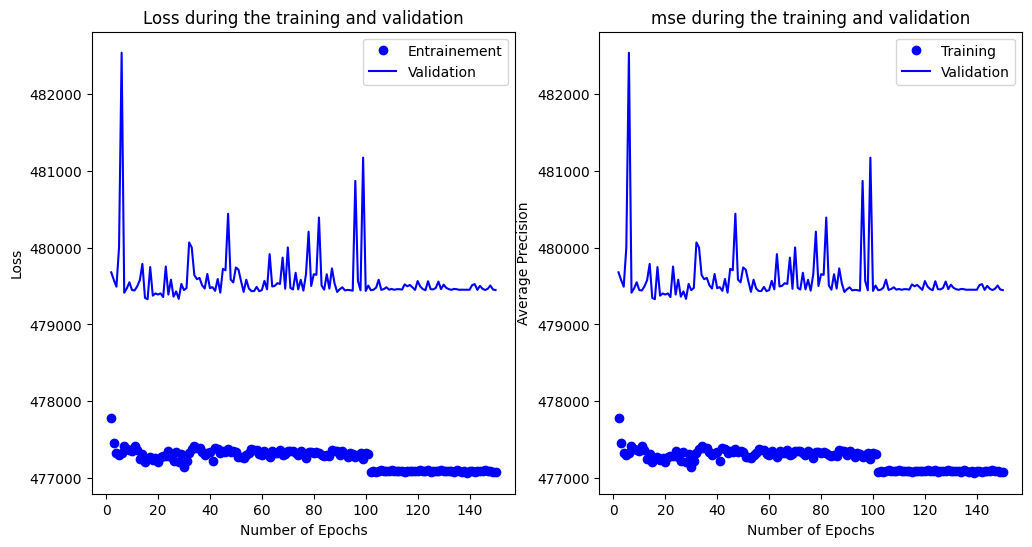

In [65]:
# Plot the loss function of the neural network

import matplotlib.pyplot as plt

# plot fonction perte

loss=history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs[1:], loss[1:], 'bo', label = 'Entrainement')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation')
plt.title('Loss during the training and validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

mse_neural = history.history['mse']
val_mse = history.history['val_mse']

plt.subplot(1,2,2)
plt.plot(epochs[1:],mse_neural[1:],'bo',label='Training')
plt.plot(epochs[1:], val_mse[1:], 'b', label='Validation')
plt.title('mse during the training and validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model.jpg')
plt.show()